In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers==2.8.0

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.8.1+cu101
transformers: 2.8.0



## Data Exploration

Download the Google Play app reviews dataset using the following commands:

In [ ]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 39.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 113MB/s]


Here is how it looks like:

In [ ]:
import pandas as pd

df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

## Data Preprocessing

Let's now load a pre-trained BERT model and the corresponding tokenizer, which converts text data into tokens. 


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
import transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Let's see how tokenization works. Here is the test sentence. Convert into tokens using the `tokenizer.tokenize` and `tokenizer.convert_tokens_to_ids` methods.



In [ ]:
sample_txt = 'Every day feels like the same during the lock down.'

tokens = tokenizer.tokenize(sample_txt)
token_id = tokenizer.convert_tokens_to_ids(tokens)

In [ ]:

print('Tokens are:')
print(tokens)
print('Token IDs are:')
print(token_id)

Tokens are:
['Every', 'day', 'feels', 'like', 'the', 'same', 'during', 'the', 'lock', 'down', '.']
Token IDs are:
[4081, 1285, 5115, 1176, 1103, 1269, 1219, 1103, 5842, 1205, 119]


BERT has special tokens for sentence separators \[SEP\] and unknown words \[UNK\]. This can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method, which takes the test sentence and encodes it into `input_ids`.

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 4081, 1285, 5115, 1176, 1103, 1269, 1219, 1103, 5842, 1205,  119,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

Use the `tokenizer.convert_ids_to_tokens` method to invert the encoded token ids (the above tensor of length 32) and visualize the sentence.

In [ ]:
tokens_inv = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
sentence = ''
for i in tokens_inv:
  if not i.startswith('['):
    if i != '.':
      sentence += ' '
    sentence += i
print(sentence)


 Every day feels like the same during the lock down.


Most reviews in the dataset contain less than around 120 tokens, but let us choose a maximum length of 160.

In [ ]:
MAX_LEN = 160

# Building the dataset

Let's now create a dataset using the tokenizer. Here is some code that does this:

In [ ]:
from torch.utils.data import Dataset

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data into 90-5-5 train-validation-test.

In [ ]:
df_train = df.sample(frac=0.9, random_state=1)
df = df.drop(df_train.index)
df_test = df.sample(frac=0.5, random_state=1)
df = df.drop(df_test.index)
df_val = df

print('Size of training dataset is:   ', len(df_train))
print('Size of testing dataset is:    ', len(df_test))
print('Size of validation dataset is: ', len(df_val))

Size of training dataset is:    14171
Size of testing dataset is:     788
Size of validation dataset is:  787


We also need to create a couple of data loaders:

In [ ]:
from torch.utils.data import DataLoader

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df['content'].to_numpy(),
    targets=df['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's have a look at an example batch from our training data loader:

In [ ]:
import torch

data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


Let's now load the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Load the model using:

In [ ]:
from transformers import BertModel, BertConfig

bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And encode our sample text:

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  # return_dict = False
)

The `last_hidden_state` is the sequence of hidden states of the last layer of the model. The `pooled_output` can be thought of as a summary of the content in the test sentence. Try printing out the sizes of `last_hidden_state` and `pooled_output`:

In [ ]:
print('Size of the hidden states:   ', last_hidden_state.shape)
print('Size of the pooled output:   ', pooled_output.shape)

Size of the hidden states:    torch.Size([1, 32, 768])
Size of the pooled output:    torch.Size([1, 768])


We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
import torch.nn as nn

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Note that our sentiment classifier takes the BERT backbone and adds a dropout layer (for regularization) and a linear dense layer, which we train using cross-entropy. Let's create an instance and move it to the GPU:

In [ ]:
device = torch.device("cuda:0")
model = SentimentClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids)

tensor([[  101, 22597,  5616,  ...,     0,     0,     0],
        [  101,  4209,  2495,  ...,     0,     0,     0],
        [  101,   146,  1274,  ...,     0,     0,     0],
        ...,
        [  101, 11568,  2716,  ...,     0,     0,     0],
        [  101,   138,  1363,  ...,     0,     0,     0],
        [  101,  2750,   119,  ...,     0,     0,     0]], device='cuda:0')


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
!pip install -qq transformers==2.8.0

In [ ]:
import torch.nn.functional as F

F.softmax(model(input_ids, attention_mask), dim=1)

# output = model(input_ids, attention_mask)

tensor([[0.5630, 0.1511, 0.2859],
        [0.5061, 0.1868, 0.3071],
        [0.6414, 0.1582, 0.2004],
        [0.4051, 0.2413, 0.3537],
        [0.5771, 0.0869, 0.3360],
        [0.5919, 0.1640, 0.2441],
        [0.5073, 0.1576, 0.3351],
        [0.5633, 0.1303, 0.3064],
        [0.5266, 0.1587, 0.3147],
        [0.6047, 0.1272, 0.2681],
        [0.5286, 0.1747, 0.2967],
        [0.4862, 0.1227, 0.3911],
        [0.5340, 0.1519, 0.3140],
        [0.3914, 0.1263, 0.4824],
        [0.7726, 0.0779, 0.1495],
        [0.4213, 0.3026, 0.2761]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

To train the model, we will use the AdamW optimizer and a linear learning-rate scheduler with no warmup steps, along with the cross-entropy loss. Five epochs (full passes through the training data should be enough) should be enough, but you can experiment with more epochs.

In [ ]:
EPOCHS = 5

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)


Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
import numpy as np

def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds==targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Let's write another function that helps us evaluate the model on a given data loader.

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds==targets)
    losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop.

In [ ]:
%%time

from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model=model,
                                      data_loader=train_data_loader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      device=device,
                                      scheduler=scheduler,
                                      n_examples=len(df_train))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model=model,
                                      data_loader=val_data_loader,
                                      loss_fn=loss_fn,
                                      device=device,
                                      n_examples=len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.41343874894460964 accuracy 0.8417190035988992
Val   loss 0.506066627157852 accuracy 0.843710292249047

Epoch 2/5
----------
Train loss 0.2203027001076481 accuracy 0.9292216498482817
Val   loss 0.5708163423929363 accuracy 0.8678526048284626

Epoch 3/5
----------
Train loss 0.14176541054923544 accuracy 0.9580834097805377
Val   loss 0.5859570736205205 accuracy 0.8716645489199493

Epoch 4/5
----------
Train loss 0.10539008374260234 accuracy 0.9693740738127161
Val   loss 0.5805639847018756 accuracy 0.8805590851334181

Epoch 5/5
----------
Train loss 0.088685419645203 accuracy 0.9727612730223697
Val   loss 0.5805639847018756 accuracy 0.8805590851334181

CPU times: user 37min 1s, sys: 26min 47s, total: 1h 3min 49s
Wall time: 1h 3min 56s


Note that we're storing the best model, indicated by the highest validation accuracy.

Plot train and validation accuracy as a function of epoch count.

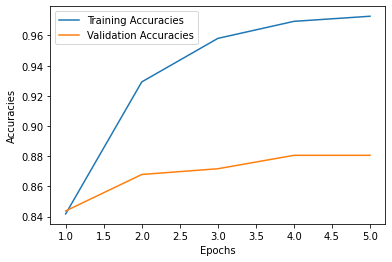

In [ ]:
plt.plot(np.arange(1, EPOCHS+1), history['train_acc'], label='Training Accuracies')
plt.plot(np.arange(1, EPOCHS+1), history['val_acc'], label='Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend()

You might try to fine-tune the parameters (learning rate, batch size) a bit more if accuracy is not good enough.


## Evaluation

So how good is our model on predicting sentiment?

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let us compare true sentiment vs predicted sentiment by plotting a confusion matrix of `y_test` vs `y_pred`.

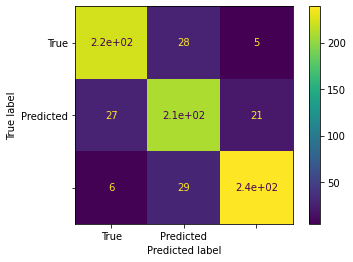

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=y_test, y_pred = y_pred)
disp = ConfusionMatrixDisplay(cm, ['True', 'Predicted'])
disp.plot()

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "I love Deep Learning! Best course evah!!!1!!"

Use your trained model to predict the sentiment expressed in `review_text`.


In [ ]:
encoding = tokenizer.encode_plus(
  review_text,
  max_length=160,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

input_ids = encoding["input_ids"].to(device)
attention_mask = encoding["attention_mask"].to(device)

outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

_, pred = torch.max(outputs, dim=1)

print(pred[0])
print('Indicating that review_text has a POSITIVE sentiment.')

tensor(2, device='cuda:0')
Indicating that review_text has a POSITIVE sentiment.


## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)